In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision import models as md
from torch import nn
from torch.nn import functional as F
import re
import math
import collections
from functools import partial
from torch.utils import model_zoo
from sklearn import metrics
from collections import Counter
import json
from efficientnet_pytorch import EfficientNet
import itertools
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, timedelta, timezone

def get_BJ_time():
    # 拿到UTC时间，并强制设置时区为UTC+0:00
    utc_dt = datetime.utcnow().replace(tzinfo=timezone.utc)
    # astimezone()将转换时区为北京时间
    bj_dt = utc_dt.astimezone(timezone(timedelta(hours=8)))
    current_time = bj_dt.strftime('%m%d_%H-%M-%S')

    return current_time

# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
SEED = 2019
seed_everything(SEED)

current_time = get_BJ_time()
print(current_time)

df_2015 = pd.read_csv('aptos-data-split/df_2015_cv.csv')
df_2019 = pd.read_csv('aptos-data-split/df_2019_cv.csv')

df = pd.concat([df_2015, df_2019]).reset_index(drop=True) # merge train val together
df['is_valid'] = [False]*df_2015.shape[0] + [True]*df_2019.shape[0]

test_df = pd.read_csv('2019data/sample_submission.csv')

bs = 32 #smaller batch size is better for training, but may take longer
sz = 256  # get model input size
# sz = EfficientNet.get_image_size(model_name)  # get model input size
tfms = get_transforms(do_flip=True,flip_vert=True, max_rotate=0, max_zoom=1.2, max_warp=0)

# df_2015 = pd.read_csv('aptos-data-split/df_2015_cv.csv')
# df_2019 = pd.read_csv('aptos-data-split/df_2019_cv.csv')

# df = pd.concat([df_2015, df_2019]).reset_index(drop=True) # merge train val together
# df['is_valid'] = [False]*df_2015.shape[0] + [True]*df_2019.shape[0]

# test_df = pd.read_csv('2019data/sample_submission.csv')

data = (ImageList.from_df(df=df,path='./',cols='path')
        .split_from_df("is_valid")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

def qk(y_pred, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_pred), y, weights='quadratic'), device='cuda:0')

model_name = 'efficientnet-b3'
model = EfficientNet.from_pretrained(model_name, num_classes=1)
df_2019 = pd.read_csv('aptos-data-split/df_2019_cv.csv')
df_2019['is_valid'] = [False]*2929 + [True]*733
data_2019 = (ImageList.from_df(df=df_2019,path='./',cols='path')
        .split_from_df("is_valid")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )
learn = Learner(data_2019, 
                model, 
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = 'output/models/')
learn.data.add_test(ImageList.from_df(test_df,
                                      '2019data',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))


ModuleNotFoundError: No module named 'fastai'

In [6]:
df_2019test = pd.read_csv('2019data/train.csv')
train_2019="2019data/train_images_ben_preprocessing_sigmaX10/"
df_2019test['path'] = df_2019test['id_code'].map(lambda x: os.path.join(train_2019, '{}.png'.format(x)))

In [7]:
df_2019test['is_valid'] = [False]*2929 + [True]*733 
data_2020 = (ImageList.from_df(df=df_2019test,path='./',cols='path')
        .split_from_df("is_valid")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )
learn = Learner(data_2020, 
                model, 
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = 'output/models/')

epoch,train_loss,valid_loss,qk,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-04
Min loss divided by 10: 5.75E-03


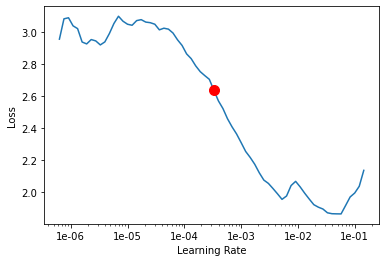

In [8]:
learn.lr_find() 
learn.recorder.plot(suggestion=True)


In [9]:
model_save_name = "EfficientNetB3WithPreprocessing"
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(20, 3.31E-04, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,1.735816,2.136886,0.409183,00:26
1,0.736906,0.724206,0.721169,00:26
2,0.500673,0.479447,0.840958,00:26
3,0.423229,0.354616,0.869519,00:26
4,0.375449,0.304834,0.895805,00:26
5,0.356062,0.319605,0.899736,00:26
6,0.304666,0.274106,0.917635,00:26
7,0.265482,0.273344,0.908425,00:26
8,0.256742,0.259727,0.902172,00:26
9,0.245167,0.341487,0.871787,00:26


Better model found at epoch 0 with valid_loss value: 2.13688588142395.
Better model found at epoch 1 with valid_loss value: 0.7242060303688049.
Better model found at epoch 2 with valid_loss value: 0.47944730520248413.
Better model found at epoch 3 with valid_loss value: 0.35461562871932983.
Better model found at epoch 4 with valid_loss value: 0.30483418703079224.
Better model found at epoch 6 with valid_loss value: 0.2741057574748993.
Better model found at epoch 7 with valid_loss value: 0.2733444571495056.
Better model found at epoch 8 with valid_loss value: 0.25972726941108704.
Better model found at epoch 12 with valid_loss value: 0.2522094249725342.
Better model found at epoch 15 with valid_loss value: 0.24549643695354462.
Epoch 19: early stopping
Model save as: EfficientNetB3WithPreprocessing


In [ ]:
learn = Learner(data_2020, 
                model, 
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = 'output/models/')
learn.load("transformed_testwithlr_stage1")

In [10]:

import scipy as sp
class OptimizedRounder(object):
    """
    Optimize threshold coefficients.
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Customized loss function.
        
        :param coef: list, shape=[4]
            Threshold.
        :param X: list, shape=[5]
            Prediction.
        :param y: list, shape=[5]
            Golden label.
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        
        # Cohen's kappa: a statistic that measures inter-annotator agreement.
        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        """
        :param X: list, shape=[5]
            Prediction.
        :param y: list, shape=[5]
            Golden label.
        """
        # new function with partial application of the given arguments and keywords.
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        # Minimization of scalar function of one or more variables.
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        """
        :param X: list, shape=[5]
            Prediction.
        :param coef: list, shape=[4]
            Threshold.
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [11]:
learn.data.add_test(ImageList.from_df(test_df,
                                      '2019data',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))
valid_preds = learn.get_preds(ds_type=DatasetType.Valid)
optR = OptimizedRounder()
optR.fit(valid_preds[0],valid_preds[1])
coefficients = optR.coefficients()
print(coefficients)

0.9169743961388123
[0.556569 1.632377 2.303207 3.041678]
